# Google Landmark Recognition

In [5]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://miro.medium.com/max/3574/1*1lL4r92AogT4_2VfFCfo9Q.jpeg")

### Importing Libraries

In [6]:
import requests
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import threading
import urllib
import cv2
import time
from sklearn.model_selection import train_test_split

from collections import Counter

import os

### Loading the Dataset

In [7]:
def check_size(url):
    r = requests.get(url, stream=True)
    return int(r.headers['Content-Length'])

def download_file(url, filename, bar=True):
    """
    Helper method handling downloading large files from `url` to `filename`. Returns a pointer to `filename`.
    """
    try:
        chunkSize = 1024
        r = requests.get(url, stream=True)
        with open(filename, 'wb') as f:
            if bar:
                pbar = tqdm( unit="B", total=int( r.headers['Content-Length'] ) )
            for chunk in r.iter_content(chunk_size=chunkSize): 
                if chunk: # filter out keep-alive new chunks
                    if bar: 
                        pbar.update (len(chunk))
                    f.write(chunk)
        return filename
    except Exception as e:
        print(e)
        return
    
def download_image_cv2_urllib(url):
    """
    Modifying the url to download the 360p or 720p version actually slows it down. 
    """
    try:
        resp = urllib.request.urlopen(url)
        foo = np.asarray(bytearray(resp.read()), dtype="uint8")
        foo = cv2.imdecode(foo, cv2.IMREAD_COLOR)
        foo = cv2.resize(foo,(128, 128), interpolation=cv2.INTER_AREA)
        return foo
    except:
        return np.array([])

In [8]:
train = pd.read_csv("train.csv")
print(train.head())
print(train.shape)
print("Number of classes {}".format(len(train.landmark_id.unique())))

                 id  landmark_id
0  17660ef415d37059            1
1  92b6290d571448f6            1
2  cd41bf948edc0340            1
3  fb09f1e98c6d2f70            1
4  25c9dfc7ea69838d            7
(1580470, 2)
Number of classes 81313


In [9]:
NUM_THRESHOLD = 250

counts = dict(Counter(train['landmark_id']))
landmarks_dict = {x:[] for x in train.landmark_id.unique() if counts[x] >= NUM_THRESHOLD}
NUM_CLASSES = len(landmarks_dict)
print("Total number of valid classes: {}".format(NUM_CLASSES))

i = 0
landmark_to_idx = {}
idx_to_landmark = []
for k in landmarks_dict:
    landmark_to_idx[k] = i
    idx_to_landmark.append(k)
    i += 1

all_urls = train['url'].tolist()
all_landmarks = train['landmark_id'].tolist()
valid_urls_dict = {x[0].split("/")[-1]:landmark_to_idx[x[1]] for x in zip(all_urls, all_landmarks) if x[1] in landmarks_dict}
valid_urls_list = [x[0] for x in zip(all_urls, all_landmarks) if x[1] in landmarks_dict]

NUM_EXAMPLES = len(valid_urls_list)
print("Total number of valid examples: {}".format(NUM_EXAMPLES))

Total number of valid classes: 302


KeyError: 'url'

## Display some images from URLs / Some URLs Visulization

In [10]:
w=20
h=20
fig=plt.figure(figsize=(16, 16))
columns = 4
rows = 4
i = 1
for url in valid_urls_list[:16]:
    im = download_image_cv2_urllib(url)
    if im.size != 0:
        fig.add_subplot(rows, columns, i)
        plt.title("Landmark: "+str(idx_to_landmark[valid_urls_dict[url.split("/")[-1]]]))
        plt.imshow(im)
        i += 1

NameError: name 'valid_urls_list' is not defined

<Figure size 1600x1600 with 0 Axes>

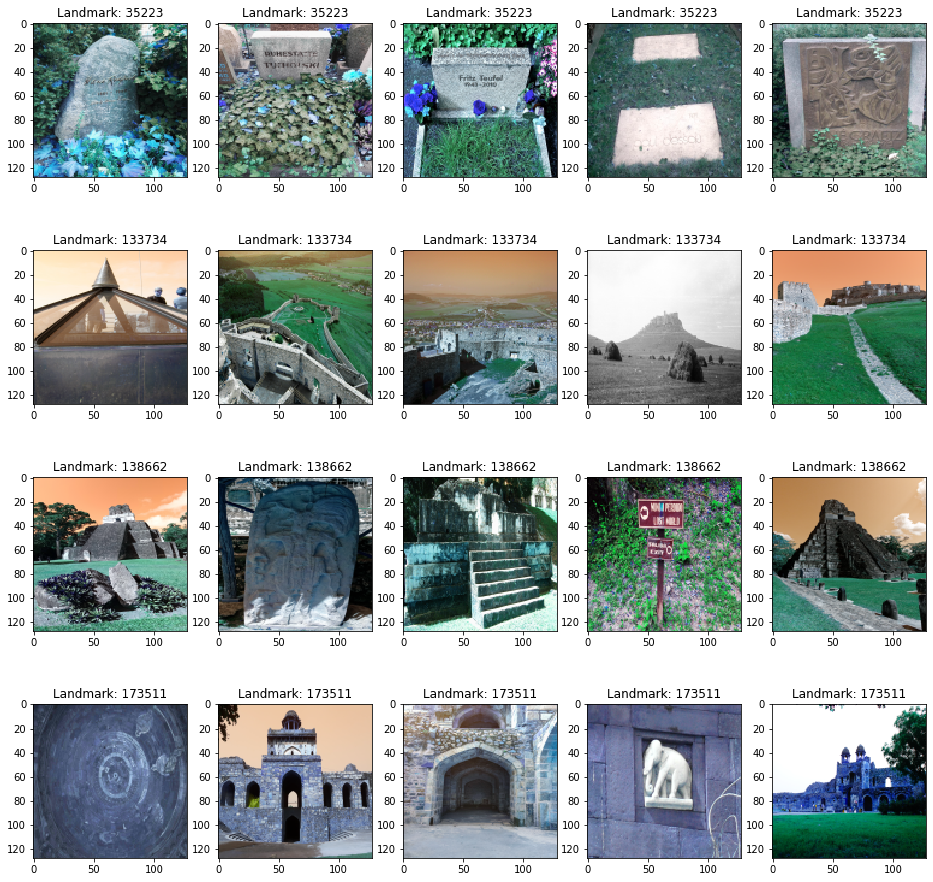

In [ ]:
w=20
h=20
fig=plt.figure(figsize=(16, 16))
columns = 5
rows = 4
landmarks = [idx_to_landmark[valid_urls_dict[x]] for x in random.sample(valid_urls_dict.keys(), rows)]
for i in range(rows):
    landmark = landmarks[i]
    urls = [x[0] for x in zip(all_urls, all_landmarks) if x[1]==landmark]
    for j in range(columns):
        im = download_image_cv2_urllib(urls[j])
        if im.size != 0:
            fig.add_subplot(rows, columns, i*columns+j+1)
            plt.title("Landmark: "+str(landmark))
            plt.imshow(im)

In [ ]:
train.head()

,id,url,landmark_id
0,6e158a47eb2ca3f6,https://upload.wikimedia.org/wikipedia/commons...,142820
1,202cd79556f30760,http://upload.wikimedia.org/wikipedia/commons/...,104169
2,3ad87684c99c06e1,http://upload.wikimedia.org/wikipedia/commons/...,37914
3,e7f70e9c61e66af3,https://upload.wikimedia.org/wikipedia/commons...,102140
4,4072182eddd0100e,https://upload.wikimedia.org/wikipedia/commons...,2474


In [ ]:
train_data = train.copy()

In [ ]:
# now open the URL
temp = 4444
print('id', train_data['id'][temp])
print('url:', train_data['url'][temp])
print('landmark id:', train_data['landmark_id'][temp])

id 3c1138a4a5369aca
url: http://upload.wikimedia.org/wikipedia/commons/7/7f/Interieur%2C_terug_gevonden_fragment_figuratief_reli%C3%ABf_-_Breda_-_20362006_-_RCE.jpg
landmark id: 51856


### Number of Landmark Id

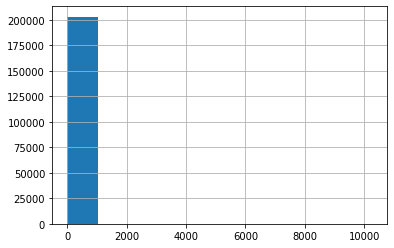

In [ ]:
train_data['landmark_id'].value_counts().hist()

## Checking for missing Data

In [ ]:
total = train_data.isnull().sum().sort_values(ascending = False)
percent = (train_data.isnull().sum()/train_data.isnull().count()).sort_values(ascending = False)
missing_train_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train_data.head()

,Total,Percent
landmark_id,0,0.0
url,0,0.0
id,0,0.0


### Occurance of landmark_id in decreasing order(Top categories)

In [ ]:
temp = pd.DataFrame(train_data.landmark_id.value_counts().head(8))
temp.reset_index(inplace=True)
temp.columns = ['landmark_id','count']
temp

,landmark_id,count
0,138982,10247
1,62798,4333
2,177870,3327
3,176528,3243
4,192931,2627
5,126637,2589
6,83144,2351
7,171772,2268


### Frequent landmark_ids

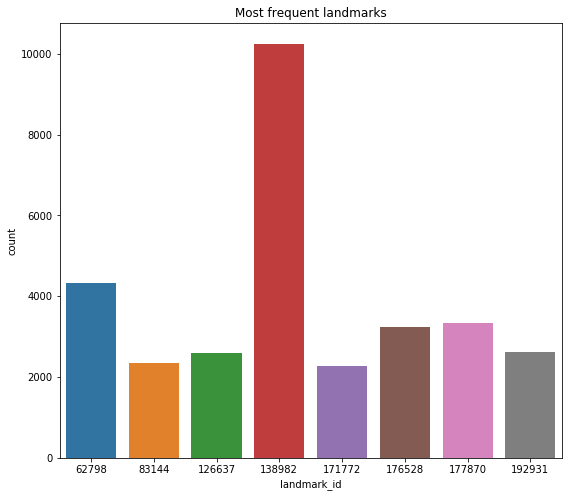

In [ ]:
plt.figure(figsize = (9, 8))
plt.title('Most frequent landmarks')
sns.set_color_codes("pastel")
sns.barplot(x="landmark_id", y="count", data=temp,
            label="Count")
plt.show()

### Occurance of landmark_id in increasing order

In [ ]:
temp = pd.DataFrame(train_data.landmark_id.value_counts().tail(8))
temp.reset_index(inplace=True)
temp.columns = ['landmark_id','count']
temp

,landmark_id,count
0,22473,1
1,70512,1
2,127852,1
3,134828,1
4,139519,1
5,24520,1
6,17242,1
7,133954,1


### Least frequent landmark_ids

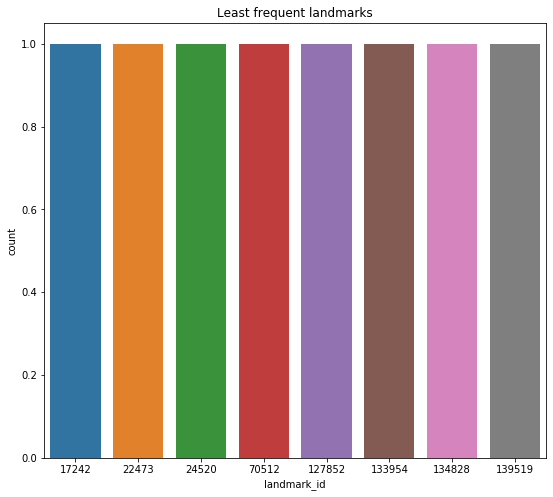

In [ ]:
plt.figure(figsize = (9, 8))
plt.title('Least frequent landmarks')
sns.set_color_codes("pastel")
sns.barplot(x="landmark_id", y="count", data=temp,
            label="Count")
plt.show()

### Number of Unique id, url and Landmark Id3

In [ ]:
train_data.nunique()

id             4132914
url            4132914
landmark_id     203094
dtype: int64

### Class distribution

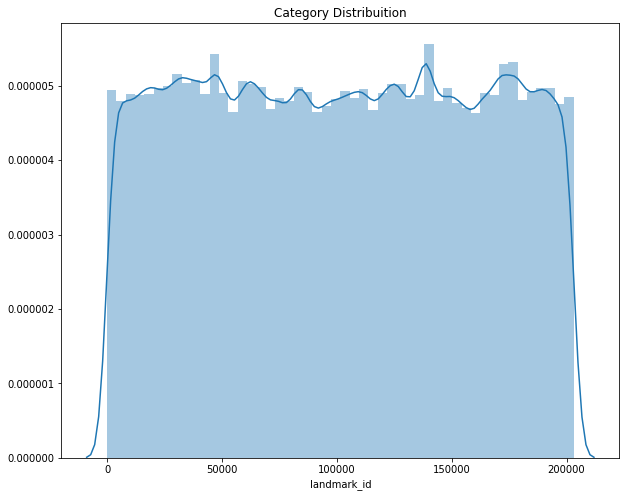

In [ ]:
plt.figure(figsize = (10, 8))
plt.title('Category Distribuition')
sns.distplot(train_data['landmark_id'])

plt.show()

In [ ]:
print("Number of classes under 20 occurences",(train_data['landmark_id'].value_counts() <= 20).sum(),'out of total number of categories',len(train_data['landmark_id'].unique()))

Number of classes under 20 occurences 152925 out of total number of categories 203094


In [ ]:
from IPython.display import Image
from IPython.core.display import HTML 

def display_category(urls, category_name):
    img_style = "width: 180px; margin: 0px; float: left; border: 1px solid black;"
    images_list = ''.join([f"<img style='{img_style}' src='{u}' />" for _, u in urls.head(12).iteritems()])

    display(HTML(images_list))

In [ ]:
print("Training data size",train_data.shape)

Training data size (4132914, 4)


In [ ]:
train_data.head(8)

,id,url,landmark_id,site_name
0,6e158a47eb2ca3f6,https://upload.wikimedia.org/wikipedia/commons...,142820,upload.wikimedia.org
1,202cd79556f30760,http://upload.wikimedia.org/wikipedia/commons/...,104169,upload.wikimedia.org
2,3ad87684c99c06e1,http://upload.wikimedia.org/wikipedia/commons/...,37914,upload.wikimedia.org
3,e7f70e9c61e66af3,https://upload.wikimedia.org/wikipedia/commons...,102140,upload.wikimedia.org
4,4072182eddd0100e,https://upload.wikimedia.org/wikipedia/commons...,2474,upload.wikimedia.org
5,5554f8798114ed04,https://upload.wikimedia.org/wikipedia/commons...,149463,upload.wikimedia.org
6,6f31b874d1a4d489,https://upload.wikimedia.org/wikipedia/commons...,6888,upload.wikimedia.org
7,16d8aa057cdd01b9,http://upload.wikimedia.org/wikipedia/commons/...,25719,upload.wikimedia.org


### Occurance of site in decreasing order(Top categories)

In [ ]:
temp = pd.DataFrame(train_data.site_name.value_counts())
temp.reset_index(inplace=True)
temp.columns = ['site_name','count']
temp


,site_name,count
0,upload.wikimedia.org,4132914


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from IPython.core.display import HTML 
from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS
from urllib import request
from io import BytesIO
%matplotlib inline 

In [ ]:
def displayLandmarkImages(urls):
    
    imageStyle = "height: 60px; margin: 2px; float: left; border: 1px solid blue;"
    imagesList = ''.join([f"<img style='{imageStyle}' src='{u}' />" for _, u in urls.iteritems()])

    display(HTML(imagesList))
    
    
def displayLandmarkImagesLarge(urls):
    
    imageStyle = "height: 100px; margin: 2px; float: left; border: 1px solid blue;"
    imagesList = ''.join([f"<img style='{imageStyle}' src='{u}' />" for _, u in urls.iteritems()])

    display(HTML(imagesList))

In [ ]:
LANDMARK_NUMBER = 5
IMAGES_NUMBER = 5
landMarkIDs = pd.Series(train['landmark_id'].value_counts().keys())[1:LANDMARK_NUMBER+1]
for landMarkID in landMarkIDs:
    url = train[train['landmark_id'] == landMarkID]['url'].head(IMAGES_NUMBER)
    displayLandmarkImagesLarge(url)


In [ ]:
### Landmark id density plot

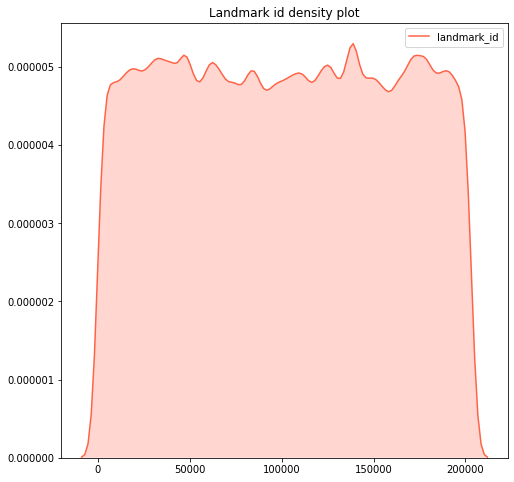

In [ ]:
plt.figure(figsize = (8, 8))
plt.title('Landmark id density plot')
sns.kdeplot(train['landmark_id'], color="tomato", shade=True)
plt.show()

In [ ]:
### Landmark id distribuition and density plot

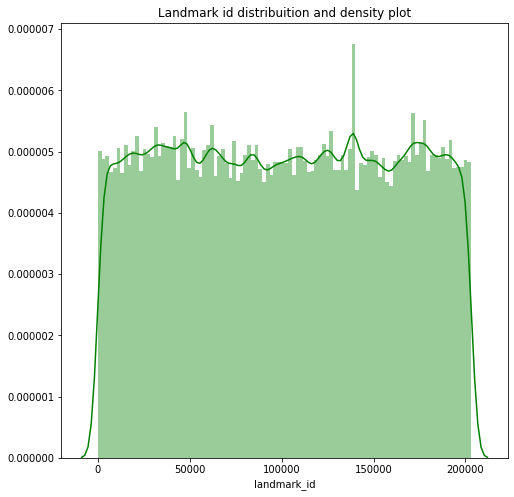

In [ ]:
plt.figure(figsize = (8, 8))
plt.title('Landmark id distribuition and density plot')
sns.distplot(train['landmark_id'],color='green', kde=True,bins=100)
plt.show()

In [ ]:
IMAGES_NUMBER = 50
landmarkId = train['landmark_id'].value_counts().keys()[5]
urls = train[train['landmark_id'] == landmarkId]['url'].head(IMAGES_NUMBER)
displayLandmarkImages(urls)

In [ ]:
LANDMARK_NUMBER = 5
IMAGES_NUMBER = 5
landMarkIDs = pd.Series(train['landmark_id'].value_counts().keys())[1:LANDMARK_NUMBER+1]
for landMarkID in landMarkIDs:
    url = train[train['landmark_id'] == landMarkID]['url'].head(IMAGES_NUMBER)
    displayLandmarkImagesLarge(url)

## End of the Jupyter Notebook